## 0. Import Libraries

In [2]:
from shapely.geometry import mapping
from cartopy.feature import ShapelyFeature
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.colors import LinearSegmentedColormap

import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
import cartopy.io.shapereader as shpreader 
import matplotlib.pyplot as plt

import cartopy
import utils
import proplot

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 0.1 Functions

In [5]:
def clip_to_turkey(idx_cosmo):
    name_variable_cosmo = 'TOT_PREC'
    idx_cosmo = idx_cosmo.where(turkey_bool==1).rename({'Tw':name_variable_cosmo})
    return idx_cosmo

## 1. Open Data

In [3]:
# change if needed
bias_algo = 'QDM_era5land' # EQM or QDM
time_frame = '198501_200512' # 208101_210012 for proj or 198501_200512 for reference
season = 'DJF' # DJF or JJA

if time_frame == '208101_210012':
    time_line = 'projection'
    
elif time_frame == '206101_208012':
    time_line = 'projection_0'
    
elif time_frame == '198501_200512':
    time_line = 'reference'

path_general = r'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data'
path_coeff = r'/mnt/e/JupyterLab/Yuksek_Lisans/msc_thesis_data/data/bias_correction'

### 1.1 Vector Data

In [4]:
# turkey vector data
turkey_bool = xr.open_dataset(fr"{path_general}/data/TOT_PREC/cosmo/BC/vectorized_turkey_mask_from_era5land.nc")

### 1.2 Model Data

#### 1.2.1 Sum

In [6]:
dt_model_sum = xr.open_dataset(fr"{path_general}/cosmo/Tr011_MPI_RF_PR_{season}_1hr_aggregated_sum_{time_frame}.nc",)
dt_model_sum = clip_to_turkey(dt_model_sum['TOT_PREC'])

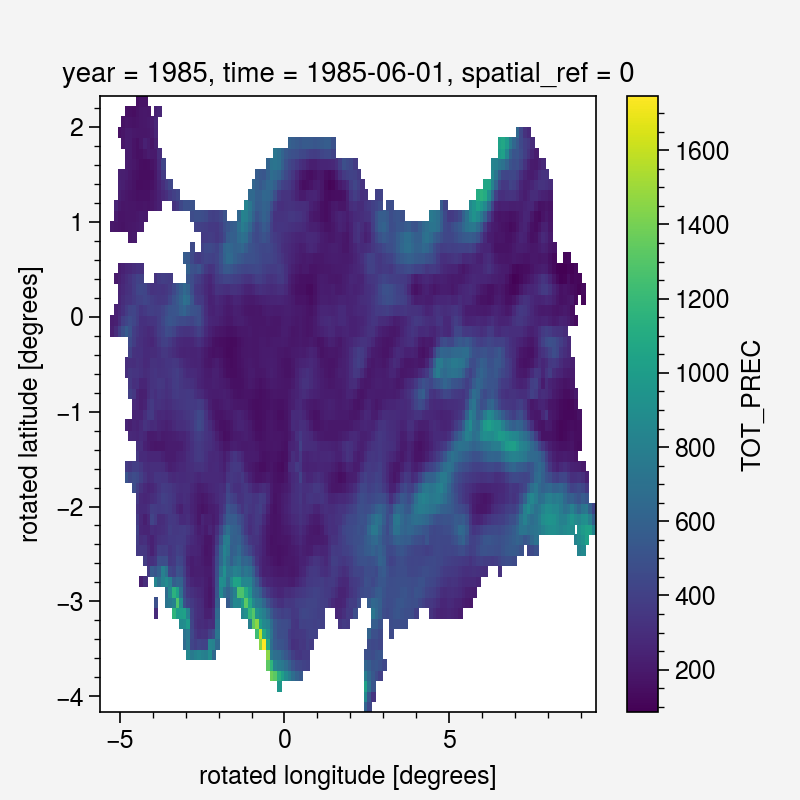

In [7]:
dt_model_sum['TOT_PREC'][0].plot()

#### 1.2.2 Max

In [10]:
dt_model_max = xr.open_dataset(fr"{path_general}/cosmo/Tr011_MPI_RF_PR_{season}_1hr_aggregated_max_{time_frame}.nc")
dt_model_max = clip_to_turkey(dt_model_max['TOT_PREC'])

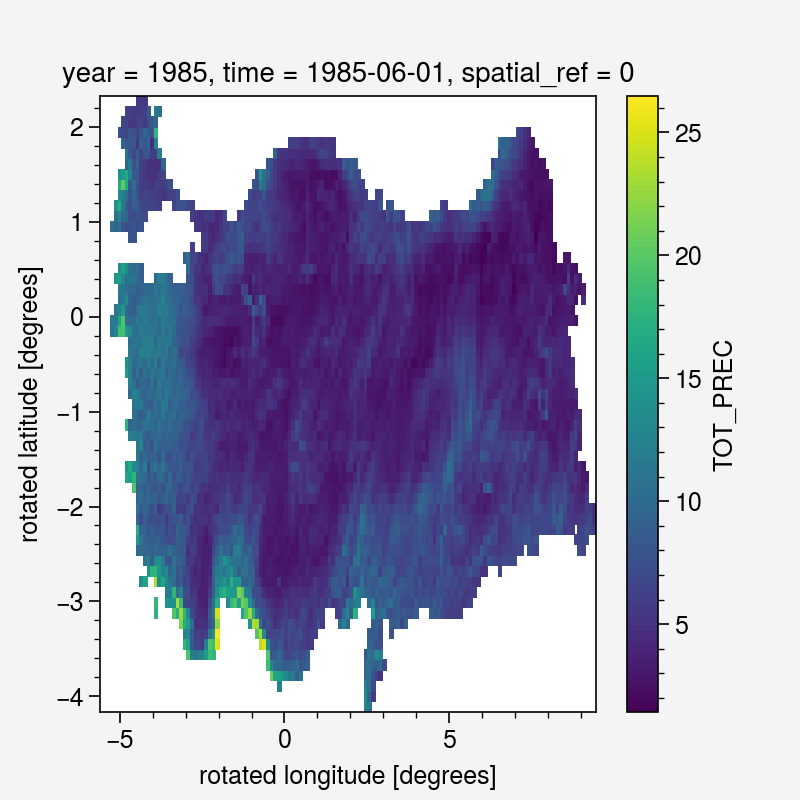

In [11]:
dt_model_max['TOT_PREC'][0].plot()

### 1.2 ERA5 Data

#### 1.2.1 Sum

In [12]:
dt_era5_sum = xr.open_dataset(fr"{path_general}/era5/era5_TOT_PREC_{season}_1hr_regrid_aggregated_sum_{time_frame}.nc")
dt_era5_sum = clip_to_turkey(dt_era5_sum['TOT_PREC'])

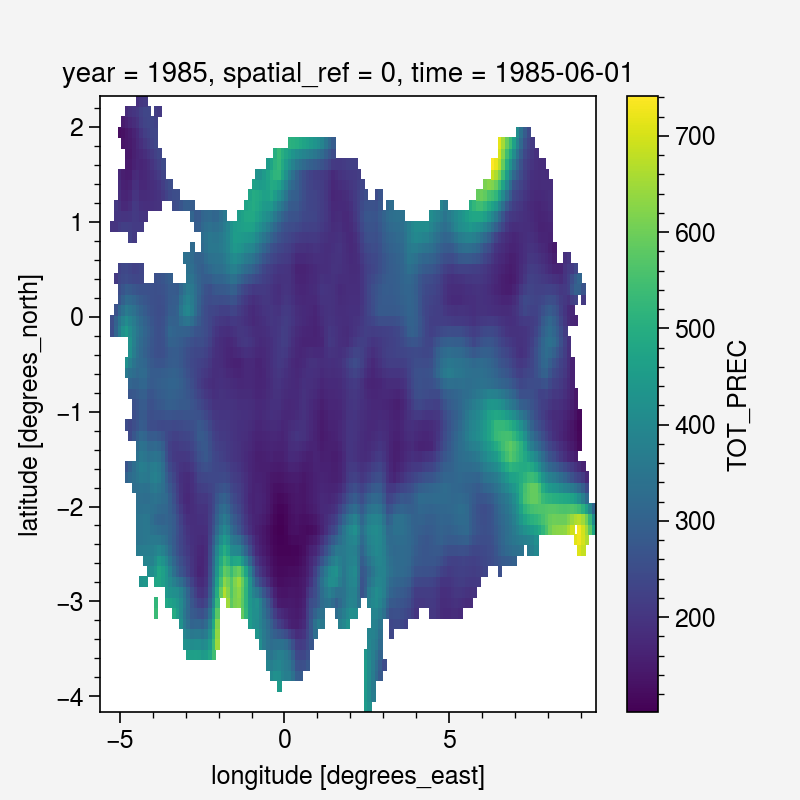

In [13]:
dt_era5_sum['TOT_PREC'][0].plot()

#### 1.2.2 Max

In [14]:
dt_era5_max = xr.open_dataset(fr"{path_general}/era5/era5_TOT_PREC_{season}_1hr_regrid_aggregated_max_{time_frame}.nc")
dt_era5_max = clip_to_turkey(dt_era5_max['TOT_PREC'])

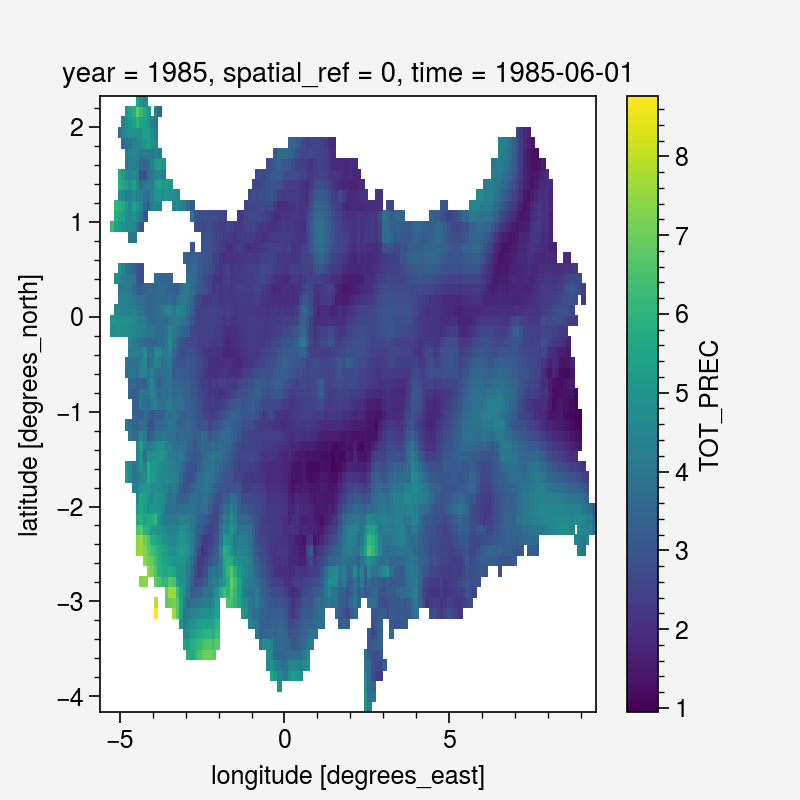

In [15]:
dt_era5_max['TOT_PREC'][0].plot()

## 2. Visualize

### 2.1 Options

In [23]:
# Parameters to change (plot) -------------------

# projection
lcc = utils.get_proj_info_model()

# fig features
fig_array = [[1, 4],
             [2, 5],
             [3, 6]
            ]

# graphic number
graphic_no = 6

# variable and dimension names
name_var = 'TOT_PREC'
name_lon = 'rlon'
name_lat = 'rlat'

# create a cmap for median of sums maps
cmap_base_opt = [
    "#dff2f7",
    "#a9dff9",
    "#8acef5",
    "#67aae1", 
    "#4aa77a", 
    "#a2cf5a", 
    "#fed755", 
    "#f29a3e", 
    "#ef6934",
    "#cf212a",
    "#620878",
    "#c611f2",
    "#db7cf2"
    
]
cmap_base = ListedColormap(cmap_base_opt)
cmap_base_opt_extend = (cmap_base(np.linspace(0, 1, len(cmap_base_opt) * 3
                                             )
                                 ) * 255
                       ).astype(np.uint8
                               )
cmap_base_extend = LinearSegmentedColormap.from_list('', 
                                                     np.array(cmap_base_opt_extend) / 255,
                                                     256
                                                    )
clevs_total = np.arange(50, 1451, 100
                       )
norm_base = BoundaryNorm(clevs_total,
                    ncolors=cmap_base_extend.N, 
                    clip=True
                        )

# create a cmap for max of maxs maps
cmap_max = LinearSegmentedColormap.from_list('Random gradient 1263', (
    # Edit this gradient at https://eltos.github.io/gradient/#Random%20gradient%201263=F94A4C-F9B54B-D0BB2C-76BC66-49B784-4962B7
    (0.000, (0.976, 0.290, 0.298)),
    (0.200, (0.976, 0.710, 0.294)),
    (0.400, (0.816, 0.733, 0.173)),
    (0.600, (0.463, 0.737, 0.400)),
    (0.800, (0.286, 0.718, 0.518)),
    (1.000, (0.286, 0.384, 0.718))))

if season == 'DJF':
    clevs_max = np.arange(1, 41, 2
                           )
elif season == 'JJA':
    clevs_max = np.arange(1, 81, 4
                           )
norm_max = BoundaryNorm(clevs_max,
                    ncolors=cmap_max.N, 
                    clip=True
                        )

# cmap for diffs
cmap_diff = proplot.Colormap('ColdHot')

if season == 'DJF':
    clevs_diff = np.arange(-32.5, 32.6, 4
                           )
    ticks = [-30, 0, 30]
elif season == 'JJA':
    clevs_diff = np.arange(-64, 65, 4
                           )
    ticks = [-60, 0, 60]

norm_diff = BoundaryNorm(clevs_diff,
                    ncolors=cmap_diff.N, 
                    clip=True
                        )

### 2.2 Plot

/tmp/ipykernel_2431/47969752.py:4: ProplotWarning: Ignoring unused projection-specific format() keyword argument(s): {'aspect': 10}
  fig, axs = proplot.subplots(fig_array,
/tmp/ipykernel_2431/47969752.py:145: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.set_aspect('equal')
/tmp/ipykernel_2431/47969752.py:148: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.axis('off')


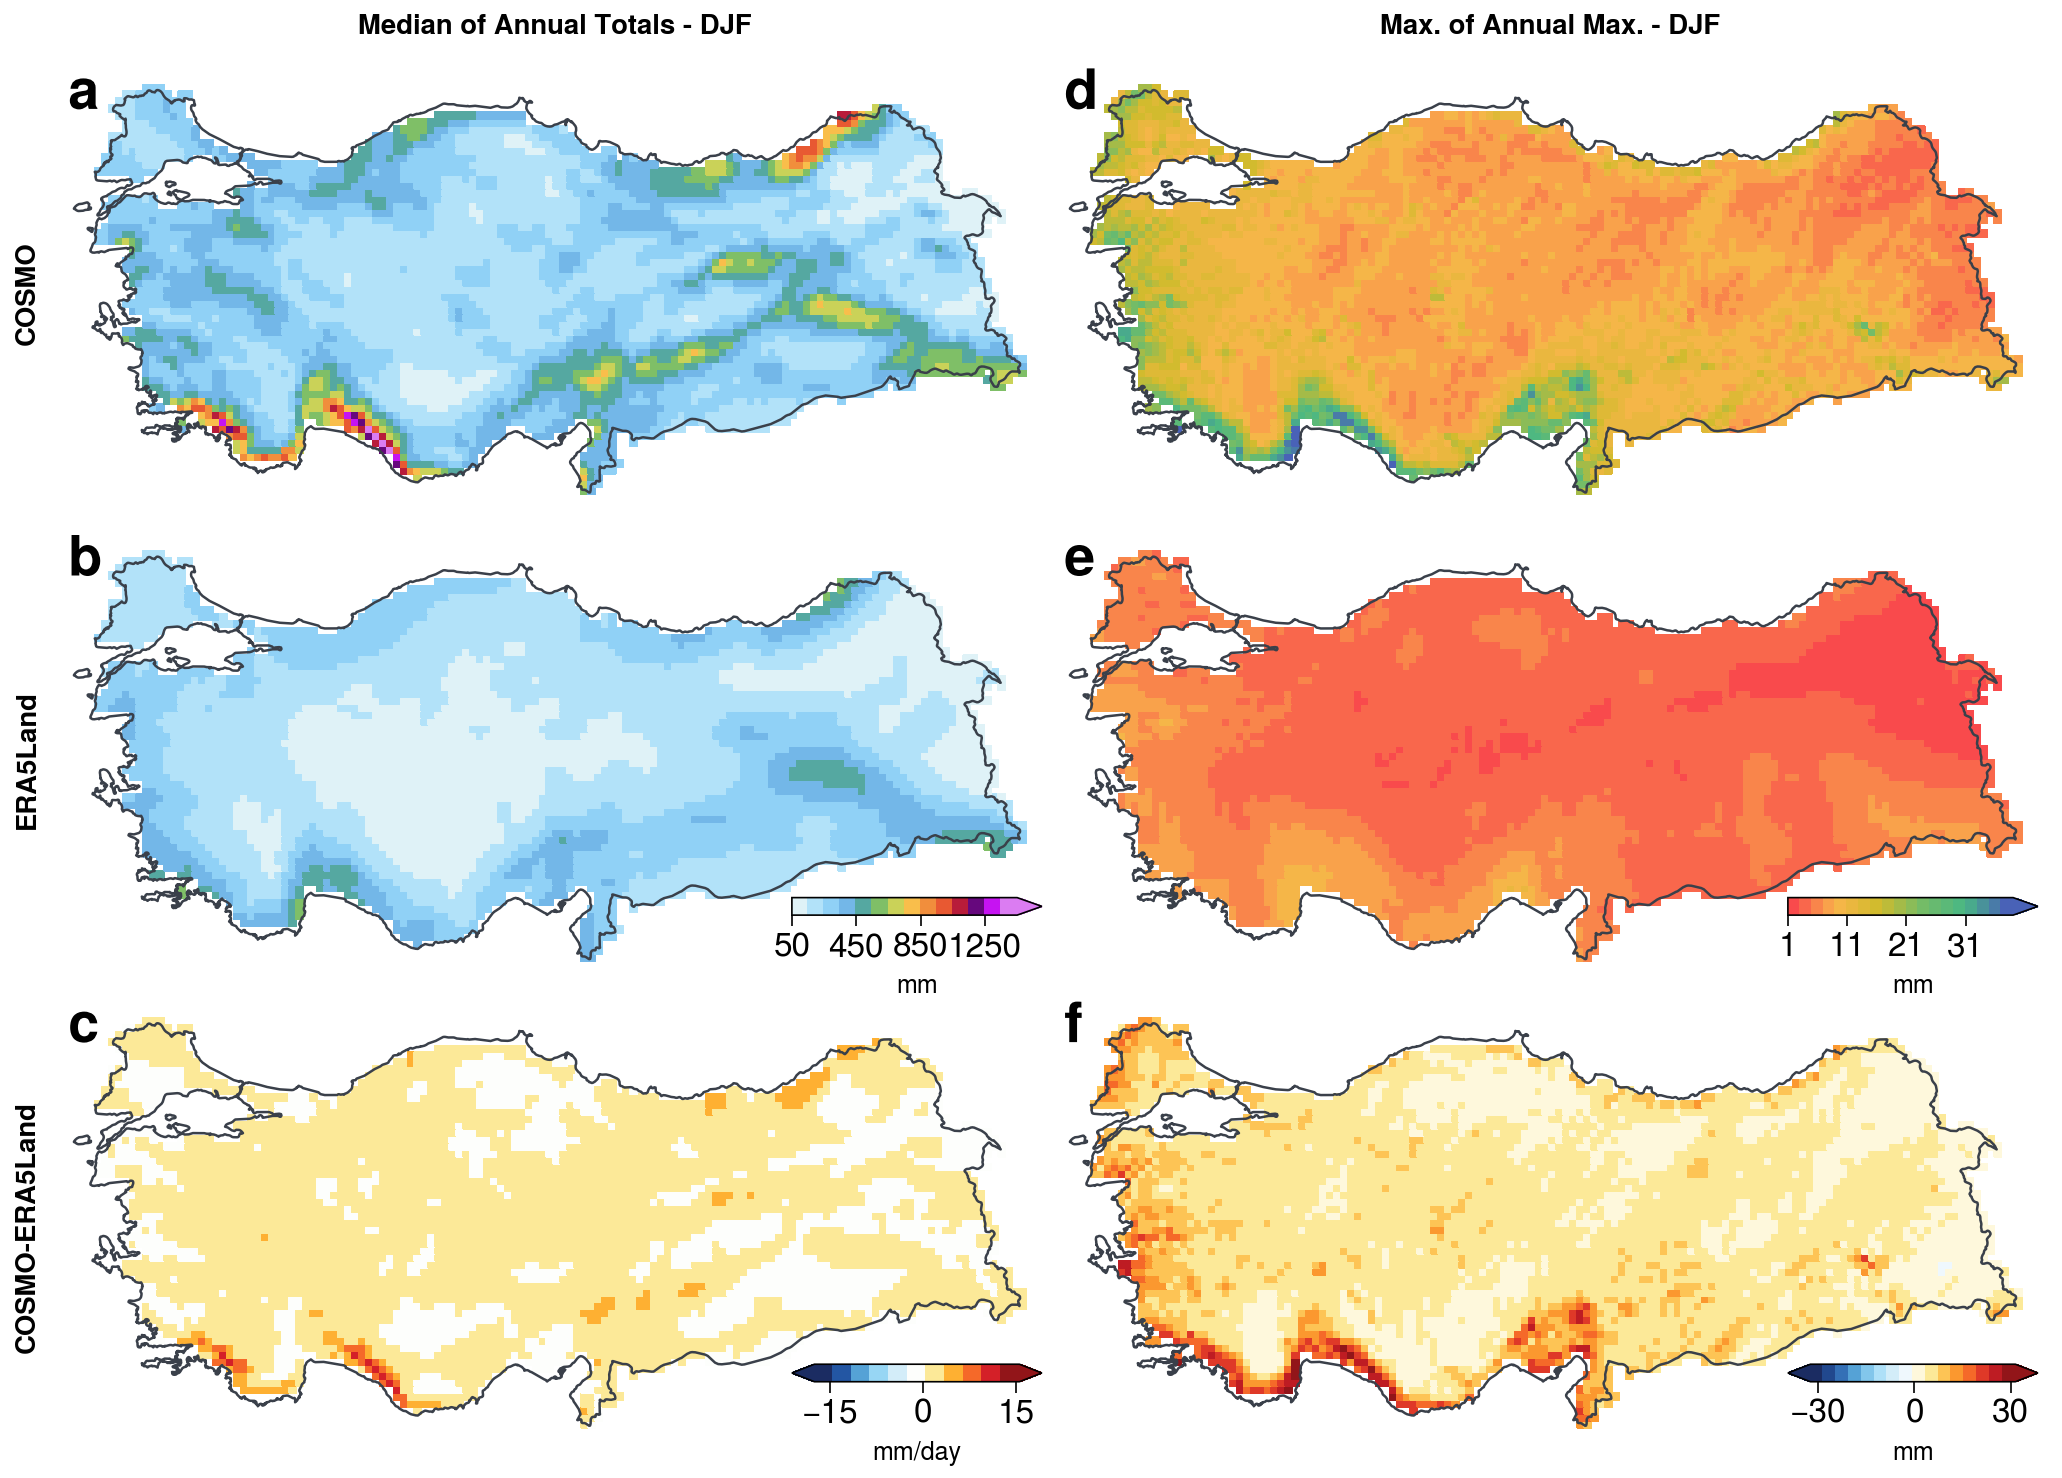

In [25]:
#%%capture

# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=10,
                            axwidth=5,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=-0.46,
                            wspace=-0.16,
                            sharey=0
                           )

# format whole figure
axs.format(abcloc='ul',
           #abcbbox = True,
           abc_kw={'size':20},
           abc=True,
           zorder=50
          )

# Turkey limits
axs.format(lonlim=(25.8, 45.1), 
           latlim=(35., 42.2), 
           longrid=False, 
           latgrid = False
          )

# format headers
axs.format(rowlabels=['COSMO', 'ERA5Land', 'COSMO-ERA5Land'],
           collabels=[fr'Median of Annual Totals - {season}', 
                      fr'Max. of Annual Max. - {season}']
          )

# geographic axes
utils.plot_geographic_features(axs, 
                               graphic_no
                              )

# meshes a and b
for idx, dt_mesh_ab in enumerate([dt_model_sum, dt_era5_sum]):
    mesh_ab = axs[idx].pcolormesh(dt_mesh_ab[name_lon],
                                  dt_mesh_ab[name_lat],
                                  dt_mesh_ab[name_var].median(dim='year'),
                                  cmap=cmap_base_extend,
                                  norm=norm_base,
                                  transform=lcc,
                                  zorder=20,
                                  extend='max'
                                 )
    # colorbar
    if idx == 1:
        axs[idx].colorbar(mesh_ab,
                     label='mm',
                     loc='lr', length=10,  # length is em widths
                     tickminor=False, alpha=0.5,
                     width=0.7,
                     labelsize = 9,
                     ticklabelsize = 12,
                     frame=False,
                     pad = 0.5
                    )
    
# meshes d and e
for idx, dt_mesh_de in enumerate([dt_model_max, dt_era5_max]):
    mesh_de = axs[idx+3].pcolormesh(dt_mesh_de[name_lon],
                                  dt_mesh_de[name_lat],
                                  dt_mesh_de[name_var].max(dim='year'),
                                  cmap=cmap_max,
                                  norm=norm_max,
                                  transform=lcc,
                                  zorder=20,
                                  extend='max'
                                 )
    # colorbar
    if idx == 1:
        axs[idx+3].colorbar(mesh_de,
                     label='mm',
                     loc='lr', length=10,  # length is em widths
                     tickminor=False, alpha=0.5,
                     width=0.7,
                     labelsize = 9,
                     ticklabelsize = 12,
                     frame=False,
                     pad = 0.5
                    )
    
# mesh c
clevs_diff_c = np.arange(-17.5, 17.6, 3)
ticks_c = [-15, 0, 15]
norm_diff_c = BoundaryNorm(clevs_diff_c,
                ncolors=cmap_diff.N, 
                clip=True
                    )
mesh_c = axs[2].pcolormesh(dt_model_sum[name_lon],
                           dt_model_sum[name_lat],
                           (dt_model_sum[name_var].median(dim='year') - 
                           dt_era5_sum[name_var].median(dim='year')) / 90, # to mm/day
                           cmap=cmap_diff,
                           norm=norm_diff_c,
                           transform=lcc,
                           zorder=20,
                           extend='both'
                           )
# colorbar for mesh c
axs[2].colorbar(mesh_c,
             label='mm/day',
             loc='lr', length=10,  # length is em widths
             tickminor=False, alpha=0.5,
             width=0.7,
             labelsize = 9,
             ticklabelsize = 12,
             frame=False,
             pad = 0.5,
             ticks = ticks_c
            )

# mesh f
mesh_f = axs[5].pcolormesh(dt_model_sum[name_lon],
                           dt_model_sum[name_lat],
                           dt_model_max[name_var].max(dim='year') - 
                           dt_era5_max[name_var].max(dim='year'),
                           cmap=cmap_diff,
                           norm=norm_diff,
                           transform=lcc,
                           zorder=20,
                           extend='both'
                           )

# colorbar for mesh f
axs[5].colorbar(mesh_f,
             label='mm',
             loc='lr', length=10,  # length is em widths
             tickminor=False, alpha=0.5,
             width=0.7,
             labelsize = 9,
             ticklabelsize = 12,
             frame=False,
             pad = 0.5,
             ticks = ticks
            )

# set the aspect ratio of the plot to "equal"
axs.set_aspect('equal')

fig.patch.set_visible(False)
axs.axis('off')

# set the background color of the figure to match the map
fig.set_facecolor('white')

#save figure
#plt.savefig(fr'{path_general}/pictures/verification_{season}_{time_frame}.jpeg',
#            bbox_inches='tight', optimize=True,
#            progressive=True, dpi=300)